In [103]:
#!/usr/bin/env python3

import os
import sys
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from readcountclass import DiffGeneTable, make_responders_dict
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [95]:
#main_data_dir = sys.argv[1]
main_data_dir = "/Users/nicolasdeneuter/Bestanden/PhD/Projects/GOA/RNAseq/readcounts/ML_pipeline"
resp_dict = make_responders_dict()
subdirmap = {}
fold_change = 3

# for each subdir in the main directory, find result files (each contrast has a different result file)
for x in os.walk(main_data_dir):
    subdir = x[0]
    if subdir == main_data_dir:
        continue
    data_files = glob(subdir+'/results*')
    # for each contrast's result:
    # make a dataframe containing a single row (ie one volunteer) containing log fold changes for each column/gene
    for data_file in data_files:
        # determine characteristics of file
        volunteer = data_file.split('/')[-2]
        contrast = data_file.split('/')[-1].replace('.txt','').replace('results_','')
        resp = resp_dict[volunteer]
        # skip day 3 vs 7 contrast because it's the difference of the other contrasts
        if contrast == '3_7':
            continue
        # read in and format data
        diff_gene_table = pd.read_csv(data_file).set_index('Unnamed: 0')
        diff_gene_table = diff_gene_table[(diff_gene_table['log2FoldChange'] > fold_change)|\
                                              (diff_gene_table['log2FoldChange'] < -fold_change)]
        # use diff_gene_tabel['padj'] < 0.1 for sig genes
        gene_folds = diff_gene_table.transpose().loc[['log2FoldChange']]
        gene_folds = gene_folds.rename(index={'log2FoldChange': '{}'.format(volunteer)}, 
                                       columns={name: '{}_{}'.format(name, contrast) for name in gene_folds.columns})
        gene_folds.columns.name = 'volunteer_resp'
        gene_col_names = [x for x in gene_folds.columns if 'gene' in x]
        gene_folds = gene_folds[gene_col_names]
        subdirmap.setdefault(volunteer, []).append(gene_folds)

In [96]:
temp_fold_frames = []
# combine dataframe on same volunteer but different contrasts into one dataframe
# result for each volunteer is a new dataframe with one row and columns containing gene+contrast info
for volunteer, gene_fold_list in subdirmap.items():
    temp_fold = pd.concat(gene_fold_list, axis = 1)
    temp_fold['response'] = resp_dict[volunteer]
    temp_fold_frames.append(temp_fold)

In [97]:
gene_fold = temp_fold_frames[0]
for i in range(1, len(temp_fold_frames)):
    gene_fold_to_add = temp_fold_frames[i]
    gene_fold = gene_fold.append(gene_fold_to_add)
    print(gene_fold.shape)
    
# replace missing values with 0
total_gene_fold = gene_fold.fillna(0)

(2, 16975)
(3, 20948)
(4, 25653)
(5, 27263)
(6, 28809)
(7, 29697)
(8, 31183)
(9, 32972)
(10, 34904)
(11, 35634)
(12, 36005)
(13, 37140)
(14, 38561)
(15, 39003)
(16, 39398)
(17, 39856)
(18, 40582)
(19, 41179)
(20, 41478)
(21, 42521)
(22, 42914)
(23, 43070)
(24, 43325)
(25, 43426)
(26, 43752)
(27, 44380)
(28, 44537)
(29, 44890)
(30, 45236)
(31, 45304)
(32, 45530)


In [98]:
X = total_gene_fold[[x for x in total_gene_fold.columns if x != 'response']]
y = total_gene_fold['response']

In [102]:
nonzerovalues = {column: np.count_nonzero(X[column]) for column in X.columns}

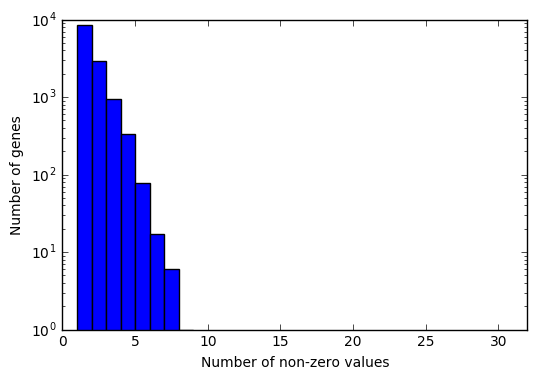

In [92]:
# plot histogram of how many non-zero values the features contain
plt.hist(list(nonzerovalues.values()), bins = range(len(X)))
plt.ylabel('Number of genes')
plt.yscale('log')
plt.xlabel('Number of non-zero values')
plt.xlim(0, len(X))
plt.show()

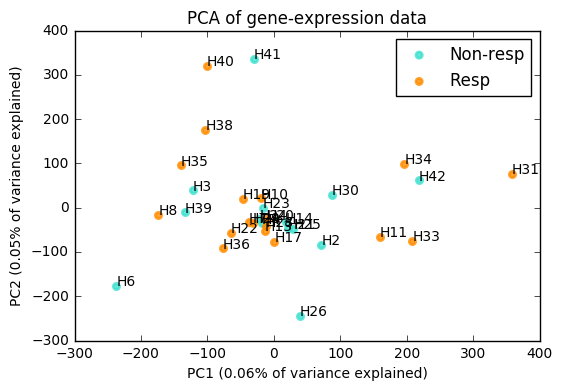

In [99]:
# remove genes with only 1 non-zero value

pca = PCA(n_components = 2)
X_r = pd.DataFrame(pca.fit(X).transform(X), index = X.index)

plt.figure()
colors = ['turquoise', 'darkorange']
target_names = ['Non-resp', 'Resp']
label = [float(x.replace('H','')) for x in X_r.index]
for color, target_name in zip(colors, target_names):
    plt.scatter(X_r[y == target_name][0], X_r[y == target_name][1], color=color, alpha=.8, lw=2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[1]))
plt.title('PCA of gene-expression data')
for i, txt in enumerate(label):
    plt.annotate('H'+str(int(txt)), (X_r[0][i],X_r[1][i]))
plt.show()

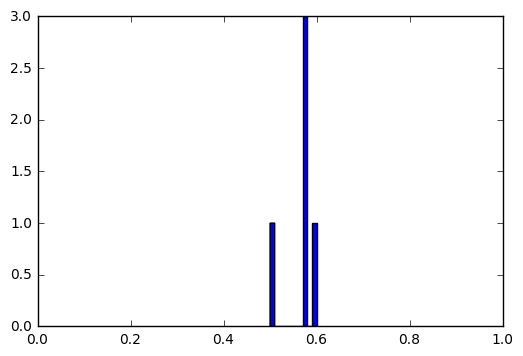

[0.5714285714285714, 0.5714285714285714, 0.5714285714285714, 0.5, 0.59999999999999998] 0.562857142857 0.0333197251134


In [101]:
accuracies = []
skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X, y):    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    rfc = RandomForestClassifier(n_estimators = 300, n_jobs=-1, random_state=0)
    rfc.fit(X_train, y_train)
    accuracies.append(rfc.score(X_test, y_test))
    
plt.figure()
plt.hist(accuracies)
plt.xlim(0, 1)
plt.show()

print(accuracies, np.mean(accuracies), np.std(accuracies))